# EIT-CEM Forward Problem

In [1]:
from EIT_CEM_app import *
%matplotlib inline

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


In [2]:
"Electrodes and Mesh"
ele_pos=electrodes_position(L=16, per_cober=0.5, rotate=0)
mesh_forward=MyMesh(r=1, n=20, n_in=80, n_out=60, electrodes_obj=ele_pos)
mesh_inverse=MyMesh(r=1, n=10, n_in=8, n_out=1, electrodes_obj=ele_pos)

#### Malhas

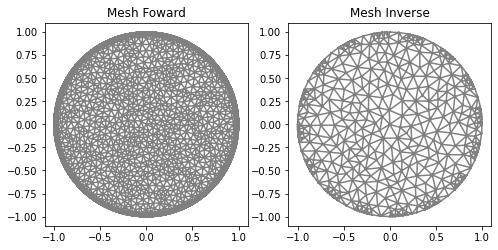

In [3]:
plt.figure(figsize=(8, 8))
plt.subplot(1,2,1)
plot(mesh_forward, title="Mesh Forward");
plt.subplot(1,2,2)
plot(mesh_inverse, title="Mesh Inverse");

## Problema Direto

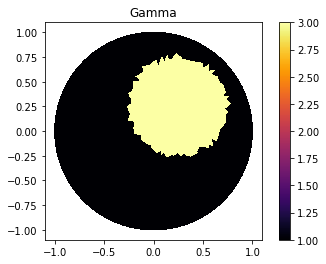

In [4]:
"Gamma function"
ValuesCells0=GammaCircle(mesh_forward,3.0,1.0,0.50, 0.25, 0.25);
gamma0=CellFunction(mesh_forward, values=ValuesCells0)

"Plot"
V_DG=FiniteElement('DG',mesh_forward.ufl_cell(),0)
gamma_forward=plot_figure(mesh_forward, V_DG, gamma0, name="Gamma");

### Forward Problem

In [5]:
"Forward Problem"
VD=FiniteElement('CG',mesh_forward.ufl_cell(),1) #Lagrange pol. degree 1
L=16                                            #Electrodes number
l=15                                             #Measurements number.
z=np.ones(L)*0.025                              #Impedance
I_all=current_method(L,l, method=2, value=1)    #Current pattern

#Solver
ForwardObject=ForwardProblem(mesh_forward,  ele_pos,  z)
list_u0, list_U0 = ForwardObject.solve_forward(VD, gamma0, I_all, l)
list_U0 = ForwardObject.sol_asarray()

In [6]:
print(len(list_U0))

240


### Solver

### Plot Noise

In [7]:
"Getting noised solution"
noise_level=0.01 #0.5%
noise_type='uniform'
if noise_level>1E-10: list_U0_noised = ForwardObject.add_noise(noise_level, noise_type, seed=1)

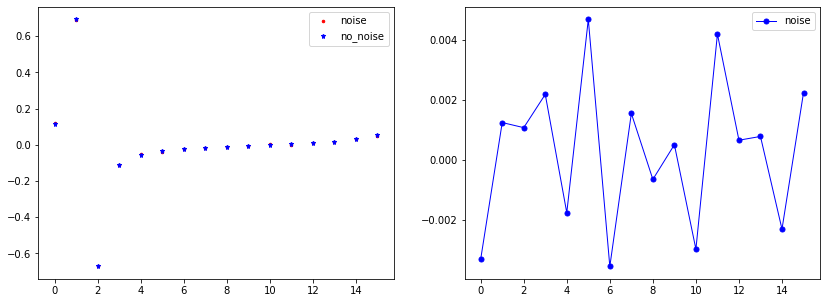

In [8]:
"Plot electrodes noise."
index=1 #Index in array

if noise_level>1E-5:
    vec_U0_noise=list_U0_noised[index*L:(index+1)*L]
    vec_U0=list_U0[index*L:(index+1)*L]
    x=range(len(vec_U0_noise))

    plt.figure(figsize=(14, 5),)
    plt.subplot(1,2,1)
    plt.plot(x, vec_U0_noise, linewidth=0,  marker='.', markersize=5, label="noise", color='red');
    plt.plot(x, vec_U0, linewidth=0,  marker='*', markersize=5, label="no_noise", color="blue");
    plt.legend()
   
    plt.subplot(1,2,2)
    plt.plot(x, vec_U0-vec_U0_noise, linewidth=1,  marker='.', markersize=10, label="noise", color="blue");
    plt.legend()
    
    plt.show()

### Solver Parameters

In [9]:
#"Select data"
#list_U0_noised=ForwardObject.select_potential(list_U0_noised, method=1)
#print(len(list_U0_noised))

In [10]:
"Object"
InverseObject=InverseProblem(mesh_inverse, ele_pos, list_U0_noised, I_all, l, z, select_pot_method=0)

"Solver Parameters"
InverseObject.set_solverconfig(step_limit=100)
InverseObject.set_NewtonParameters(mu_i=0.90, mumax=0.999, nu=0.99, R=1)
#InverseObject.set_InnerParameters(inner_method='Landweber', land_a=20)
InverseObject.set_InnerParameters(inner_method='ME', ME_reg=1E-4)
#InverseObject.set_InnerParameters(inner_method='CG')
#InverseObject.set_InnerParameters(inner_method='LM', LM_c0=0.95, LM_q=0.5)
#InverseObject.set_InnerParameters(inner_method='Tikhonov', Tik_c0=0.95, Tik_q=0.1)

"Noise Parameters"
tau=1.15
InverseObject.set_NoiseParameters(tau=tau, noise_level=0.01)
print(f"Discrepance stop {tau*noise_level*100}% residue")

"Noise Parameters"
InverseObject.set_answer(gamma0, mesh_forward)
InverseObject.weight_value=True
#MyCellsgamma_k=np.ones(mesh_inverse.num_cells())*2.0
#InverseObject.set_firstguess(MyCellsgamma_k)

Discrepance stop 1.15% residue


In [11]:
#Solver
InverseObject.solve_inverse()

Error (%)= 60.88038156617592 Residue (%)= 13.997533561957077  step: 0 Inner step:  0
mu_n 0.9
Error (%)= 58.22122889773102 Residue (%)= 11.81872437848733  step: 1 Inner step:  59
mu_n 0.9
Error (%)= 55.71402186718749 Residue (%)= 9.955415960829711  step: 2 Inner step:  59
mu_n 0.8991
Error (%)= 53.33700092663766 Residue (%)= 8.380265499434023  step: 3 Inner step:  59
mu_n 0.8982009
Error (%)= 51.08350652247603 Residue (%)= 7.081275121037661  step: 4 Inner step:  58
mu_n 0.8973026990999999
Error (%)= 48.890835673704714 Residue (%)= 6.01473366272825  step: 5 Inner step:  57
mu_n 0.8964053964008999
Error (%)= 46.72391722979452 Residue (%)= 5.152741186407804  step: 6 Inner step:  55
mu_n 0.895508991004499
Error (%)= 44.517108720780236 Residue (%)= 4.448890774397066  step: 7 Inner step:  53
mu_n 0.8946134820134944
Error (%)= 42.23349442542045 Residue (%)= 3.861965722946085  step: 8 Inner step:  51
mu_n 0.893718868531481
Error (%)= 39.80127880064973 Residue (%)= 3.3382194296056182  step: 9 I

In [12]:
"Getting the result"
gamma_k=InverseObject.gamma_k
list_U=InverseObject.list_U

"Getting data_summary"
innerstep_vec=InverseObject.innerstep_vec
res_vec=InverseObject.res_vec
mun_vec=InverseObject.mun_vec
error_vec=InverseObject.error_vec

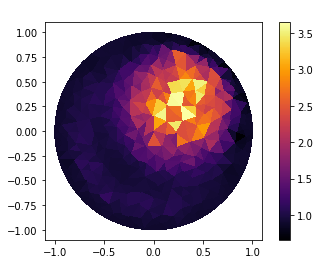

In [13]:
"Plot result"
V_DG=FiniteElement('DG',mesh_inverse.ufl_cell(),0)
gamma_k=plot_figure(mesh_inverse, V_DG, gamma_k, name=" ");

jet


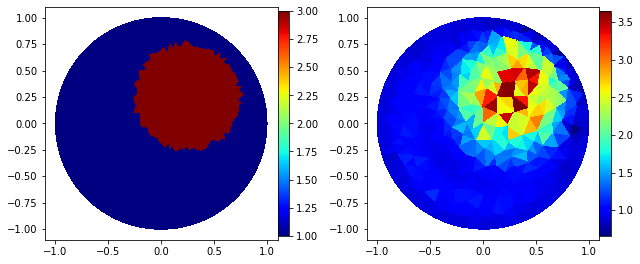

In [20]:
"Fancy plot"
cmap='jet'
fig=plt.figure(figsize=(9, 9))
plt.subplot(1,2,1);
p=plot(gamma_forward);
p.set_cmap(cmap)
plt.colorbar(p,fraction=0.046, pad=0.0);

plt.subplot(1,2,2);
p=plot(gamma_k);
p.set_cmap(cmap);
plt.colorbar(p,fraction=0.046, pad=0.0);
fig.tight_layout()
print(cmap)

#### Potencial in first measurement.

In [16]:
"Checking results"
import pandas as pd #To print dataframe
vec_U_plot=np.vstack((list_U0_noised, list_U))
data=pd.DataFrame(vec_U_plot[:,0:16].T)
experiments=["Expected", "Calculed"]
data.columns = experiments
data

,Expected,Calculed
0,0.757461,0.757174
1,-0.692175,-0.687288
2,-0.115752,-0.119533
3,-0.065626,-0.065225
4,-0.044408,-0.047313
5,-0.041311,-0.036335
6,-0.025108,-0.028307
7,-0.024192,-0.021700
8,-0.015879,-0.015498
9,-0.010993,-0.009159


#### Plot error

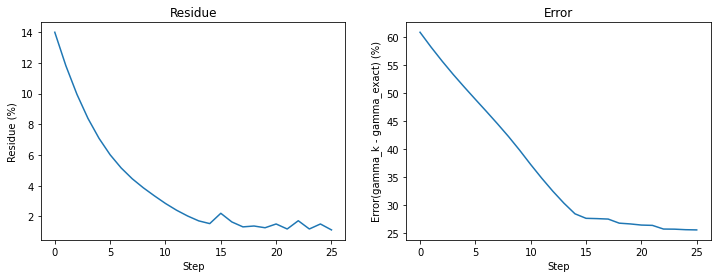

In [17]:
plt.figure(figsize=(12, 4));
"Residue Plot"
plt.subplot(1,2,1)
plt.ylabel('Residue (%)');
plt.xlabel('Step');
plt.title('Residue');
plt.plot(range(0,len(res_vec)), res_vec);

"Error plot"
plt.subplot(1,2,2)
plt.ylabel('Error(gamma_k - gamma_exact) (%)');
plt.xlabel('Step');
plt.title('Error');
plt.plot(range(0,len(error_vec)), error_vec);

#### Summary Data

In [19]:
summary_data=np.vstack((error_vec, res_vec, innerstep_vec, mun_vec))
data=pd.DataFrame(summary_data.T)
experiments=["Error (%)", "Residue (%) ", "Inner Step", "mu_n"]
data.columns = experiments
data

,Error (%),Residue (%),Inner Step,mu_n
0,60.880382,13.997534,0.0,0.000000
1,58.221229,11.818724,59.0,0.900000
2,55.714022,9.955416,59.0,0.900000
3,53.337001,8.380265,59.0,0.899100
4,51.083507,7.081275,58.0,0.898201
5,48.890836,6.014734,57.0,0.897303
6,46.723917,5.152741,55.0,0.896405
7,44.517109,4.448891,53.0,0.895509
8,42.233494,3.861966,51.0,0.894613
9,39.801279,3.338219,51.0,0.893719
